In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime
from typing import Tuple
import codecs, json
import seaborn as sb
import tikzplotlib

# Inputs

In [2]:
LOADS = 'out/loads.csv'

# (unix) timestamp of time offset
INITIAL_TIME = 1247270400

# time slot length
DELTA = 10 * 60
DELTA_ALIAS = '10T' # see: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

# adjusts flexibility of trend; increase to make more flexible; default is `0.05`
CHANGEPOINT_PRIOR_SCALE = 0.05

# number of samples of the predicted distribution
NUMBER_OF_SAMPLES = 1000

# number of predicted time slots
WINDOW = 100

# Preparation

In [3]:
l = pd.read_csv(LOADS)

## Preparing date times

In [4]:
def prepare_df(load_type: str) -> pd.DataFrame:
  df = l[[load_type]].rename(columns={load_type: 'y'})
  df['ds'] = df.index
  df['ds'] = (INITIAL_TIME + df['ds'] * DELTA).apply(lambda x: datetime.fromtimestamp(x))
  return df

## Fitting the model

In [5]:
def fit_model(df: pd.DataFrame) -> Prophet:
  m = Prophet(changepoint_prior_scale=CHANGEPOINT_PRIOR_SCALE, mcmc_samples=NUMBER_OF_SAMPLES)
  m.fit(df)
  return m

## Making predictions

In [6]:
def predict(m: Prophet) -> Tuple[pd.DataFrame, pd.DataFrame]:
  future = m.make_future_dataframe(periods=WINDOW, freq=DELTA_ALIAS)
  print(future)
  forecast = m.predict(future)
  return (future, forecast)

## Sanitizing predictions

In [7]:
def sanitize_prediction(prediction: np.array) -> np.array:
  prediction[prediction < 0] = 0
  return prediction

# Execution

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporad


Gradient evaluation took 0.000114 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000153 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.53 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.00014 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.4 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000111 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.11 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (War

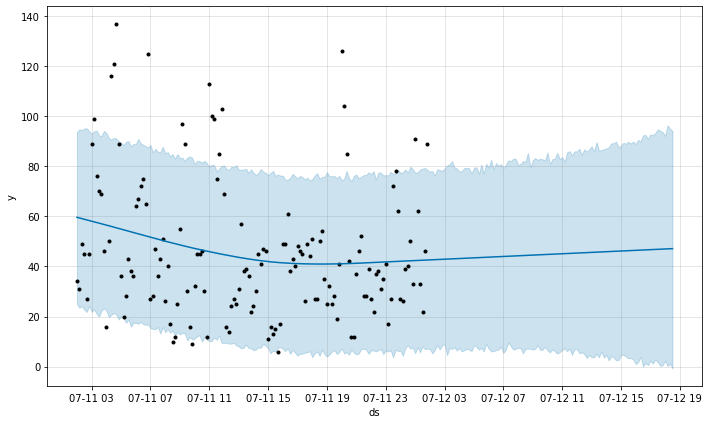

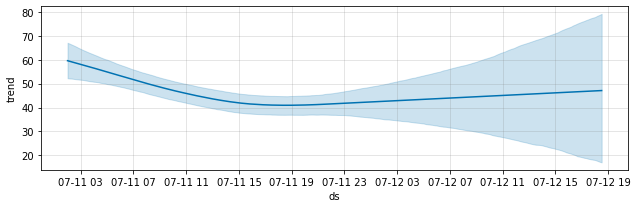

In [8]:
predictions = {}

for load_type in l.columns:
  df = prepare_df(load_type)
  m = fit_model(df)
  future, forecast = predict(m)
  m.plot(forecast)
  tikzplotlib.save('out/prediction_timeseries.tex')
  m.plot_components(forecast)
  predictions[load_type] = np.array([sanitize_prediction(p) for p in m.predictive_samples(future)['yhat']])

CDF of initial and final predictions.

In [ ]:
sb.ecdfplot(predictions['(0, 0)'][-WINDOW])
sb.ecdfplot(predictions['(0, 0)'][-1])
tikzplotlib.save('out/prediction_cdf.tex')

# Store predictions

Saves predictions as a JSON dump. For each load type the dump constains a list of predictions for each time slot (past and future). A prediction consists of a list of samples.

In [ ]:
json.dump({k: v.tolist() for k, v in predictions.items()}, codecs.open('out/predictions.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)